In [1]:
import os

import numpy as np
import random
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader

In [2]:
###############################################################################
# 주어진 결과와 정확히 비교하기 위한 random seed 고정
###############################################################################

seed = 0  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)

In [3]:
train = pd.read_csv('../data/G_train.csv')
test = pd.read_csv('../data/G_test.csv')

In [4]:
user2idx = {user:idx for idx, user in enumerate(train['user_code'].unique())}
train['user_idx'] = train['user_code'].map(user2idx)
idx2user = {idx:user for idx, user in enumerate(train['user_code'].unique())}

In [5]:
item2idx = {item:idx for idx, item in enumerate(train['rest_code'].unique())}
train['rest_idx'] = train['rest_code'].map(item2idx)
idx2item = {idx:item for idx, item in enumerate(train['rest_code'].unique())}

In [6]:
test_user2idx = {user:idx for idx, user in enumerate(test['user_code'].unique())}
test['user_idx'] = test['user_code'].map(user2idx)
test_idx2user = {idx:user for idx, user in enumerate(test['user_code'].unique())}

In [7]:
test_item2idx = {item:idx for idx, item in enumerate(test['rest_code'].unique())}
test['rest_idx'] = test['rest_code'].map(item2idx)
test_idx2item = {idx:item for idx, item in enumerate(test['rest_code'].unique())}

In [8]:
train['rating'] = 1

In [9]:
test['rating'] = 1

In [10]:
test.iloc[58691,5] = 2758

In [11]:
data = pd.concat((train,test))

In [12]:
data['rest_idx'] = data['rest_idx'].astype(int)

In [13]:
data

,userid,rest,user_code,rest_code,user_idx,rest_idx,rating
0,5b61c7658f8242cb2a1b1028,1.172647e+07,166651,2073,0,0,1
1,5b61c7658f8242cb2a1b1028,2.140700e+07,166651,1604,0,1,1
2,5b61c7658f8242cb2a1b1028,1.176442e+07,166651,1160,0,2,1
3,5b61c7658f8242cb2a1b1028,1.987767e+07,166651,1571,0,3,1
4,5b61c7658f8242cb2a1b1028,1.100141e+09,166651,658,0,4,1
...,...,...,...,...,...,...,...
65359,6353b5db1566f10006660c21,1.116538e+09,173687,1923,32679,1427,1
65360,63568cefbc1c4a789f7aec09,1.222516e+09,188377,858,32680,1022,1
65361,63568cefbc1c4a789f7aec09,1.647491e+09,188377,1025,32680,317,1
65362,6396b0ffadfbb231c28da55d,6.301172e+08,320304,2120,32681,1338,1


In [40]:
tmp = data.groupby('user_idx')['rest_idx'].unique().to_frame().reset_index()

In [41]:
tmp

,user_idx,rest_idx
0,0,"[0, 1, 2, 3, 4, 5, 6, 2076, 2388]"
1,1,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
2,2,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 974, 80]"
3,3,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4..."
4,4,"[49, 50, 51, 52, 53, 54, 55, 56, 32, 57, 58, 5..."
...,...,...
32677,32677,"[113, 1581, 946, 1293, 1291, 186, 2387, 1529, ..."
32678,32678,"[760, 503, 52, 755, 105, 1224]"
32679,32679,"[1574, 416, 1334, 1685, 240, 212, 2490, 218, 1..."
32680,32680,"[341, 338, 1644, 535, 337, 1281, 407, 1022, 317]"


In [42]:
train2 = pd.DataFrame(columns=['user_idx', 'rest_idx'])
train2['user_idx'] = tmp['user_idx']
train2['rest_idx'] = tmp['rest_idx'].apply(lambda x: x[0:-2])

In [47]:
train2

,user_idx,rest_idx
0,0,"[0, 1, 2, 3, 4, 5, 6]"
1,1,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
2,2,"[24, 25, 26, 27, 28, 29, 30, 31, 32]"
3,3,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4..."
4,4,"[49, 50, 51, 52, 53, 54, 55, 56, 32, 57, 58, 5..."
...,...,...
32677,32677,"[113, 1581, 946, 1293, 1291, 186, 2387]"
32678,32678,"[760, 503, 52, 755]"
32679,32679,"[1574, 416, 1334, 1685, 240, 212, 2490, 218, 1..."
32680,32680,"[341, 338, 1644, 535, 337, 1281, 407]"


In [54]:
test2 = pd.DataFrame(columns=['user_idx', 'rest_idx'])
test2['user_idx'] = tmp['user_idx']
test2['rest_idx'] = tmp['rest_idx'].apply(lambda x: x[-2:])

In [55]:
test2

,user_idx,rest_idx
0,0,"[2076, 2388]"
1,1,"[2226, 462]"
2,2,"[974, 80]"
3,3,"[344, 1182]"
4,4,"[389, 443]"
...,...,...
32677,32677,"[1529, 1620]"
32678,32678,"[105, 1224]"
32679,32679,"[773, 1427]"
32680,32680,"[1022, 317]"


In [56]:
train2.isna().sum()

user_idx    0
rest_idx    0
dtype: int64

In [57]:
test2.isna().sum()

user_idx    0
rest_idx    0
dtype: int64

In [65]:
list(train2['rest_idx'][0])

[0, 1, 2, 3, 4, 5, 6]

In [15]:
data_matrix = data.pivot(index='user_idx', columns='rest_idx', values='rating')

In [16]:
auto_rec_df = data_matrix.copy().fillna(0)

In [17]:
auto_rec_df

rest_idx,0,1,2,3,4,5,6,7,8,9,...,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868
user_idx,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
train_rec_X, test_rec_X, train_rec_y, test_rec_y = train_test_split(
    auto_rec_df, auto_rec_df, test_size=0.1, random_state=seed,
)
print('학습 데이터 크기:', train_rec_X.shape, train_rec_y.shape)
print('테스트 데이터 크기:', test_rec_X.shape, test_rec_y.shape)

학습 데이터 크기: (29413, 2869) (29413, 2869)
테스트 데이터 크기: (3269, 2869) (3269, 2869)


In [19]:
train_rec_X.nunique()

rest_idx
0       2
1       2
2       2
3       2
4       2
       ..
2864    2
2865    2
2866    2
2867    2
2868    2
Length: 2869, dtype: int64

In [20]:
train_rec_X

rest_idx,0,1,2,3,4,5,6,7,8,9,...,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868
user_idx,,,,,,,,,,,,,,,,,,,,,
9155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_rec_dataset = TensorDataset(torch.FloatTensor(np.array(train_rec_X)), torch.FloatTensor(np.array(train_rec_y)))
test_rec_dataset = TensorDataset(torch.FloatTensor(np.array(test_rec_X)), torch.FloatTensor(np.array(test_rec_y)))

In [70]:
train_rec_dataset

In [66]:
train_rec_X

rest_idx,0,1,2,3,4,5,6,7,8,9,...,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868
user_idx,,,,,,,,,,,,,,,,,,,,,
9155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
train_rec_y

rest_idx,0,1,2,3,4,5,6,7,8,9,...,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868
user_idx,,,,,,,,,,,,,,,,,,,,,
9155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
train_rec_X.nunique()

rest_idx
0       2
1       2
2       2
3       2
4       2
       ..
2864    2
2865    2
2866    2
2867    2
2868    2
Length: 2869, dtype: int64

In [69]:
train_rec_y.nunique()

rest_idx
0       2
1       2
2       2
3       2
4       2
       ..
2864    2
2865    2
2866    2
2867    2
2868    2
Length: 2869, dtype: int64

In [22]:
def activation_layer(activation_name='relu'):
    """
    Construct activation layers
    
    Args:
        activation_name: str, name of activation function
        emb_dim: int, used for Dice activation
    Return:
        activation: activation layer
    """
    if activation_name is None:
        activation = None
    elif isinstance(activation_name, str):
        if activation_name.lower() == 'sigmoid':
            activation = nn.Sigmoid()
        elif activation_name.lower() == 'tanh':
            activation = nn.Tanh()
        elif activation_name.lower() == 'relu':
            activation = nn.ReLU()
        elif activation_name.lower() == 'leakyrelu':
            activation = nn.LeakyReLU()
        elif activation_name.lower() == 'none':
            activation = None
    elif issubclass(activation_name, nn.Module):
        activation = activation_name()
    else:
        raise NotImplementedError("activation function {} is not implemented".format(activation_name))

    return activation

In [23]:
class AutoRec(nn.Module):
    """
    AutoRec
    
    Args:
        - input_dim: (int) input feature의 Dimension
        - emb_dim: (int) Embedding의 Dimension
        - hidden_activation: (str) hidden layer의 activation function.
        - out_activation: (str) output layer의 activation function.
    Shape:
        - Input: (torch.Tensor) input features,. Shape: (batch size, input_dim)
        - Output: (torch.Tensor) reconstructed features. Shape: (batch size, input_dim)
    """
    def __init__(self, input_dim, emb_dim, hidden_activation, out_activation):
        super(AutoRec, self).__init__()
        
        # initialize Class attributes
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        
        # define layers
        self.encoder = nn.Linear(self.input_dim, self.emb_dim)
        self.hidden_activation_function = activation_layer(hidden_activation)
        self.decoder = nn.Linear(self.emb_dim, self.input_dim)
        self.out_activation_function = activation_layer(out_activation)
        
        self.apply(self._init_weights)
        
    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, input_feature):
        h = self.encoder(input_feature)
        h = self.hidden_activation_function(h)
        
        output = self.decoder(h)
        output = self.out_activation_function(output)
        
        return output

In [24]:
class AutoRec_loss_fn(nn.Module):
    """
    AutoRec_loss_fn
    
    Args:
        - loss_fn: (nn.Module) 사용할 Loss Function
    Shape:
        - Input1: (torch.Tensor) Model의 예측 결과. Shape: (batch size,)
        - Input2: (torch.Tensor) 정답. Shape: (batch size,)
        - Output: (torch.Tensor) Observable한 데이터에 대해서만 계산한 Loss. Shape: ()
    """
    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index = np.where(y_for_compute != 0)
        loss = self.loss_fn(pred[index], y[index])
        return loss

In [25]:
######## Hyperparameter ########

batch_size = 128
data_shuffle = True
input_dim = data['rest_idx'].nunique()
emb_dim = 512
hidden_activation = 'relu'
out_activation = 'relu'
epochs = 2
learning_rate = 0.01
gpu_idx = 0

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_rec_dataloader = DataLoader(train_rec_dataset, batch_size=batch_size, shuffle=data_shuffle)
test_rec_dataloader = DataLoader(train_rec_dataset, batch_size=batch_size, shuffle=False)

model = AutoRec(input_dim, emb_dim, hidden_activation, out_activation).to(device)

loss_fn = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
err_fn = AutoRec_loss_fn(nn.L1Loss().to(device)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (batch+1) % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    
    return train_loss


def test_loop(dataloader, model, loss_fn, err_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0
    test_err = 0
    tot = np.empty(shape=(1,2869))
    
    with torch.no_grad():
        # tot = np.empty(shape=(1,2869))
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            if err_fn is not None:
                test_err += err_fn(pred, y).item()
    tot = np.vstack([tot,pred.cpu().numpy()])
    print(pred.shape)
    print(tot.shape)
    test_loss /= num_batches
    test_err /= num_batches
    if err_fn is not None:
        print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}\n\tError: {(test_err):>8f}")
    else:
        print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}")
    return test_loss, test_err, tot


In [27]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, err_fn, optimizer, epochs):
    train_loss, test_loss, test_err = list(), list(), list()

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_result= train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(train_result)
        test_result = test_loop(test_dataloader, model, loss_fn, err_fn)
        test_loss.append(test_result[0])
        test_err.append(test_result[1])

        if t == (epochs-1):
            test_pred = test_result[2]
        print("-------------------------------\n")
    print("Done!")

    return train_loss, test_loss, test_err, test_pred


In [28]:
train_loss, test_loss, test_err, test_result = train_and_test(train_rec_dataloader, test_rec_dataloader, model, loss_fn, err_fn, optimizer, epochs)

Epoch 1
-------------------------------
Loss: 0.074950 | [12672/29413]
Loss: 0.034036 | [25472/29413]
torch.Size([101, 2869])
(102, 2869)
Test Error:
	Avg Loss: 0.057900
	Error: 0.137214
-------------------------------

Epoch 2
-------------------------------
Loss: 0.026546 | [12672/29413]
Loss: 0.032411 | [25472/29413]
torch.Size([101, 2869])
(102, 2869)
Test Error:
	Avg Loss: 0.025050
	Error: 0.089277
-------------------------------

Done!


In [29]:
test_result

array([[6.90401751e-310, 6.90401751e-310, 4.67504266e-310, ...,
        4.05133830e-321, 5.29638372e-321, 6.80822460e-321],
       [7.77017295e-001, 8.84313703e-001, 8.73479366e-001, ...,
        1.13511121e+000, 0.00000000e+000, 0.00000000e+000],
       [7.83394873e-001, 7.96051145e-001, 7.99138129e-001, ...,
        1.03419638e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [9.54694569e-001, 1.01839495e+000, 9.72016990e-001, ...,
        1.58239746e+000, 0.00000000e+000, 2.75045522e-002],
       [8.65822792e-001, 9.52069044e-001, 9.04400945e-001, ...,
        1.63344574e+000, 0.00000000e+000, 0.00000000e+000],
       [9.18236017e-001, 1.00817561e+000, 9.13629353e-001, ...,
        1.66428804e+000, 0.00000000e+000, 0.00000000e+000]])

In [30]:
test_result.shape

(102, 2869)

In [31]:
test_loss

[0.057899816075096956, 0.025050018909994674]

In [32]:
len(test_loss)

2

In [33]:
train_loss

[0.1813714520762796, 0.03350660122283127]

In [34]:
len(train_loss)

2

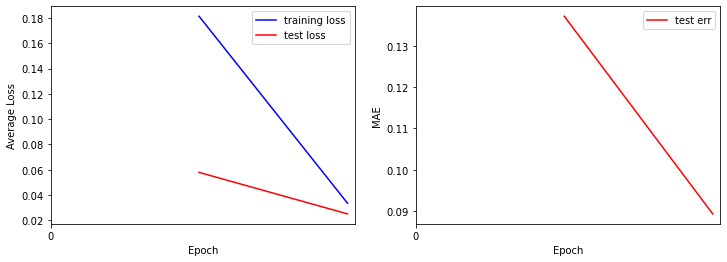

In [35]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('MAE')
err_ax.legend()

plt.show()

In [36]:
train_rec_dataloader